# Previsión de órdenes de taxi

La empresa "Dear Taxi" ha recopilado datos históricos sobre los pedidos de taxis en los aeropuertos. Para atraer a más conductores durante el período de carga máxima, debe predecir el número de pedidos de taxi para la próxima hora. Construye un modelo para esa predicción.

El valor de la métrica *RMSE* en la muestra de ensayo no debe ser superior a 48.

Usted necesita para:

1. Cargue los datos y reinícielos una hora a la vez.
2. Analizar los datos.
3. Entrenar diferentes modelos con diferentes hiperparámetros. Hacer una muestra de prueba del 10% de los datos originales.
4. Comprobar los datos de la muestra de ensayo y extraer conclusiones.


Los datos están en el archivo ¹taxi.csv¹. El número de pedidos está en la columna ¹num_orders³ (de inglés *número de pedidos*, "número de pedidos").

## Preparacion

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split, TimeSeriesSplit, GridSearchCV
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from statsmodels.tsa.seasonal import seasonal_decompose
from catboost import CatBoostRegressor
import catboost as cat

In [2]:
data = pd.read_csv('/datasets/taxi.csv', index_col=[0], parse_dates=[0])
data.sort_index(inplace=True)

In [3]:
# Vamos a recompilar por 1 hora

data = data.resample('1H').sum()

In [4]:
data.head(10)

,num_orders
datetime,
2018-03-01 00:00:00,124
2018-03-01 01:00:00,85
2018-03-01 02:00:00,71
2018-03-01 03:00:00,66
2018-03-01 04:00:00,43
2018-03-01 05:00:00,6
2018-03-01 06:00:00,12
2018-03-01 07:00:00,15
2018-03-01 08:00:00,34


<AxesSubplot:xlabel='datetime'>

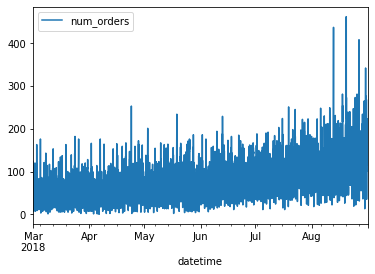

In [5]:
data.plot()

In [6]:
data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 4416 entries, 2018-03-01 00:00:00 to 2018-08-31 23:00:00
Freq: H
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   num_orders  4416 non-null   int64
dtypes: int64(1)
memory usage: 69.0 KB


## Analisis

In [7]:
# Tendencias de los datos de estudio
decomposed = seasonal_decompose(data)

# Tome la primera semana en el conjunto de datos
decomposedWeek = seasonal_decompose(data['2018-03-04':'2018-03-12'])
decomposedFewDays = seasonal_decompose(data['2018-03-04':'2018-03-06'])

# Y también al azar en abril y último en agosto
decomposedMonth_apr = seasonal_decompose(data['2018-04-01':'2018-05-01'])
decomposedMonth_aug = seasonal_decompose(data['2018-07-31':'2018-08-31'])

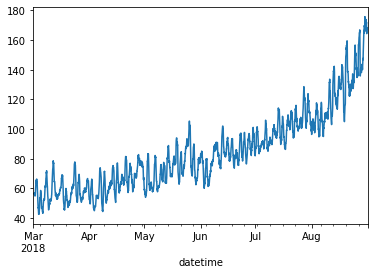

In [8]:
decomposed.trend.plot();

# en general, vemos un aumento en órdenes

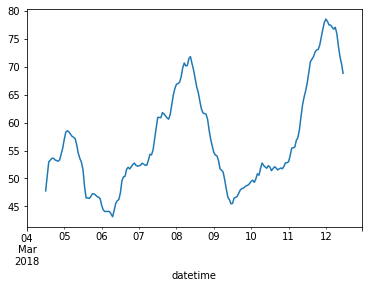

In [9]:
decomposedWeek.trend.plot();

# durante la primera semana se varía el número de pedidos

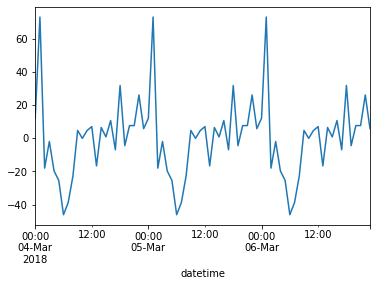

In [10]:
decomposedFewDays.seasonal.plot();

# tendencia del reloj

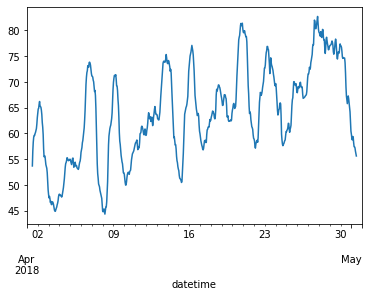

In [11]:
# abril

decomposedMonth_apr.trend.plot();

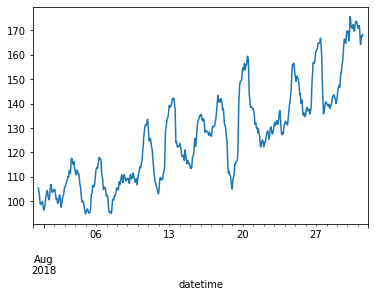

In [12]:
# agosto

decomposedMonth_aug.trend.plot();

Se creará una función llamada make_features que realizará los siguientes pasos:

- añadir el factor mes y el factor día sobre la base de la tendencia general;
- Se añadirá el factor del día de la semana, ya que hay una gran variación en el gráfico de semanas;
- Añadir el factor hora, como podemos ver picos de actividad durante el día;
- Añadir desfase (desfase).

In [13]:
df = data.copy(deep=True)

In [14]:
def make_features(df, max_lag, rolling_sum_size):
    df['month'] = df.index.month
    df['day'] = df.index.day
    df['dayofweek'] = df.index.dayofweek
    df['hour'] = df.index.hour
    for lag in range(1, max_lag + 1):
        df['lag_{}'.format(lag)] = df['num_orders'].shift(lag)
    df['rolling_sum'] = df['num_orders'].shift().rolling(rolling_sum_size).mean()
    return df

In [15]:
make_features(df, 47, 50)
df.shape

(4416, 53)

In [16]:
df.head(5)

,num_orders,month,day,dayofweek,hour,lag_1,lag_2,lag_3,lag_4,lag_5,...,lag_39,lag_40,lag_41,lag_42,lag_43,lag_44,lag_45,lag_46,lag_47,rolling_sum
datetime,,,,,,,,,,,,,,,,,,,,,
2018-03-01 00:00:00,124,3,1,3,0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 01:00:00,85,3,1,3,1,124.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 02:00:00,71,3,1,3,2,85.0,124.0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 03:00:00,66,3,1,3,3,71.0,85.0,124.0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 04:00:00,43,3,1,3,4,66.0,71.0,85.0,124.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [17]:
# quitar los espacios en blanco

df = df.dropna()
df.shape

(4366, 53)

- La descomposición muestra que el número de pedidos aumenta con el tiempo, lo que indica un aumento de la demanda.

- La estacionalidad muestra que la mayor demanda de taxis se produce por la noche cuando el transporte público no funciona.

- Se puede decir que el proceso es no estacionario, es decir, las características cambian con el tiempo.

- Se puede concluir de la tendencia que el servicio de taxi se utiliza cada vez más en el tiempo.

- La demanda alcanza su punto máximo el lunes y aumenta de mediados de semana a viernes, mientras que los fines de semana son menos activos.

- El análisis de la semana pasada muestra que hay horas con la mayor demanda, y el momento más popular para pedir un taxi es por la noche, y luego la demanda cae por la mañana.

## Aprendizaje

In [18]:
train, test = train_test_split(df, shuffle=False, test_size=0.1)
train = train.dropna()

In [19]:
train_features = train.drop('num_orders', axis = 1)
train_target = train['num_orders']
test_features = test.drop('num_orders', axis = 1)
test_target = test['num_orders']

In [20]:
train_features_split, val_features, train_target_split, val_target = train_test_split(train_features, train_target, test_size=0.2, shuffle=False)

### Linear Regression


In [21]:
modelLR = LinearRegression()
modelLR.fit(train_features_split, train_target_split)
predictionLR = modelLR.predict(val_features)
rmse = mean_squared_error(val_target, predictionLR) ** .5

print(rmse)

31.044400004181384


### CatBoostRegressor

In [22]:
model_Cat = CatBoostRegressor(random_state=42)
hyperparams = [{'depth': [3],
                'learning_rate': [0.1],
                'iterations': [300],
                'verbose': [False]
               }]
my_cv = TimeSeriesSplit(n_splits=3).split(train_features_split)
clf = GridSearchCV(model_Cat, hyperparams, cv=my_cv, scoring='neg_mean_squared_error')
clf.fit(train_features_split, train_target_split)

predictions = clf.predict(val_features)
rmse = mean_squared_error(val_target, predictions) ** .5

print(rmse)

32.66299978624266


In [23]:
best_params_CBR = clf.best_params_
print(best_params_CBR)

{'depth': 3, 'iterations': 300, 'learning_rate': 0.1, 'verbose': False}


### DecisionTreeRegressor

In [24]:
best_rmse = 48
for max_lag in range(1, 15):
    for rolling_mean_size in range(1, 35):
        for max_depth in range(2, 21):
            model = DecisionTreeRegressor(max_depth=max_depth, random_state=12345)
            model.fit(train_features_split, train_target_split)
            predictions = model.predict(val_features)
            # Оценка RMSE на валидационной выборке
            rmse = mean_squared_error(val_target, predictions) ** .5
            if rmse < best_rmse:
                best_rmse = rmse
                best_max_lag = max_lag
                best_rolling_mean_size = rolling_mean_size
                best_max_depth = max_depth
print('лучшее RMSE =', best_rmse)
print('при отставании', best_max_lag)
print('при окне', best_rolling_mean_size)
print('при глубине', best_max_depth)


лучшее RMSE = 35.22416086027399
при отставании 1
при окне 1
при глубине 7


## Prueba

El mejor resultado del modelo de Regresión Lineal (rmse = 31.04). Lo probaremos.

44.617295936686126


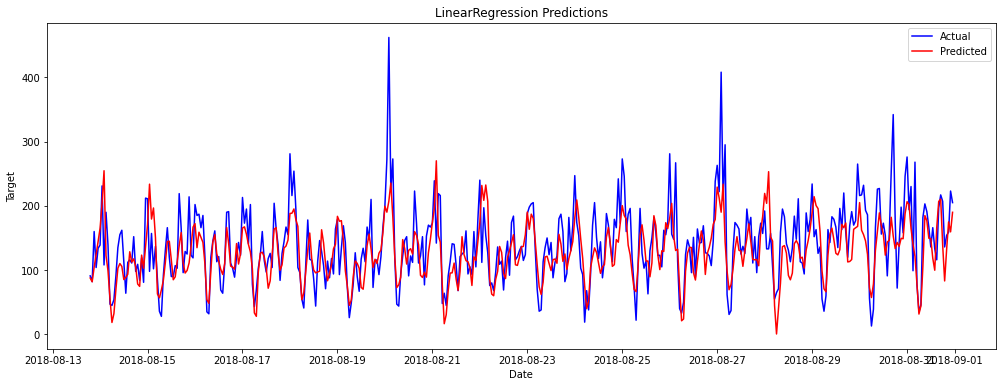

In [26]:
modelLR = LinearRegression()
modelLR.fit(train_features, train_target)
predictionLR = modelLR.predict(test_features)
rmse = mean_squared_error(test_target, predictionLR) ** .5
print(rmse)

plt.figure(figsize=(17, 6))
plt.plot(test_target.index, test_target, 'b-', label='Actual')
plt.plot(test_target.index, predictionLR, 'r-', label='Predicted')
plt.xlabel('Date')
plt.ylabel('Target')
plt.title('LinearRegression Predictions')
plt.legend()
plt.show()

## Retirada

El mejor resultado mostró el modelo LinearRegression con rmse = 44,62.